<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#Calculation" data-toc-modified-id="Calculation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculation</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Bootstrapping" data-toc-modified-id="Bootstrapping-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bootstrapping</a></span></li></ul></div>

# Preamble

In [1]:
##############################
''' Packages '''


import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from dask.diagnostics import ProgressBar
# ProgressBar().register()
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
rb = plt.cm.RdBu
bm = plt.cm.Blues

In [2]:

import warnings
warnings.filterwarnings('ignore')
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')


In [3]:
path_2 = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/Pre xr/MJO_df.pickle'
pickle_in_2 = open(path_2, 'rb')
MJO_df = pickle.load(pickle_in_2)

In [4]:
path = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/RMM.pickle'
pickle_in = open(path, 'rb')
RMM = pickle.load(pickle_in)

RMM = RMM.reset_index()
RMM = RMM.rename({'Date':'time'}, axis = 1)
RMM = RMM.set_index(['time'])

In [5]:
path = '/home/student.unimelb.edu.au/aborowiak/Desktop/Code/Scripts/MJO/Station/station_xr.nc'
MJO_station = xr.open_mfdataset(path)
station_xr = MJO_station.sel(time = slice(RMM.index[0], '2010'))

# Calculation

In [6]:
RMM_active = RMM[RMM['Amplitude'] >= 1]
RMM_inactive = np.array(RMM[RMM['Amplitude'] < 1].index)

In [7]:
def mjo_phase_data(data_sub, enhanced_phases):
    enhanced_dates = np.array(RMM_active[RMM_active['Phase'].isin(enhanced_phases)].index)
    suppressed_dates = np.array(RMM_active[~RMM_active['Phase'].isin(enhanced_phases)].index)
    
    enhanced_data = data_sub.where(data_sub.time.isin(enhanced_dates))
    suppressed_data = data_sub.where(data_sub.time.isin(suppressed_dates))
    inactive_data = data_sub.where(data_sub.time.isin(RMM_inactive))

    return enhanced_data, suppressed_data, inactive_data
    

In [8]:
def enhanced_phase_function(lon):
    if lon < 120:
        enhanced_phases = [4,5]
    if lon >= 120 and lon <140:
        enhanced_phases = [4,5,6]
    else:
        enhanced_phases = [4,5,6,7]
        
    return enhanced_phases

In [9]:
def into_xr(storage):
    
    xr_file = xr.Dataset({'precip':(('location','month'),np.array(storage)),
                  'lat':(('location'), np.array(MJO_df.Lat).astype(float)),
                  'lon':(('location'), np.array(MJO_df.Lon).astype(float))
                  },
                 {'location':station_xr.location.values, 'month':[10,11,12,1,2,3]})
    
    return xr_file

In [10]:
def drop_surplus_data(xr_file):
    xr_file = xr_file.drop('lat')
    xr_file = xr_file.drop('lon')
    xr_file = xr_file.drop('station_name')
    
    return xr_file

In [11]:
# This function find the extremes for a specific station. THe a

def return_extremes(data, q):
    
    # Finding the extreme threshhold for each of the months
    data_exthresh = data.precip.groupby('time.month').reduce(np.nanpercentile,q= q, dim = 'time')
    
    
    # Now going through and finding all of the extremes for each month
    months = [10,11,12,1,2,3]
    ex_storage = []
    
    for month in months:
        
        # This is just the data for a single month
        data_m = data.where(data.time.dt.month == month, drop = True)
        threshold = data_exthresh.sel(month = 1)
        data_ex  = data_m.where(data_m.precip >= threshold)
        ex_storage.append(data_ex)
        
    xr_file = xr.concat(ex_storage, pd.Index(months, name = 'month'))
    
    
    xr_file = drop_surplus_data(xr_file)
    
    return xr_file

In [37]:
# This return the fraction of extrem rainfall events occuring in a phase

def calculate_month_count(data,data_ex):
    # The data_ex has been divided into months, but the data has not.
    
    data_count = data.precip.groupby('time.month').count(dim = 'time')
    data_ex_count = data_ex.precip.groupby('month').count(dim = 'time')
    
    frac = data_ex_count/data_count
    
    return frac
    

In [38]:

def calculate_station_count(data, q, per):
    # For loops that goes through all stations
    enhanced_storage = []
    suppressed_storage = []
    inactive_storage = []

    for station in np.array([data.location.values])[0][0:]:

        # Getting the data just from these years
        data_sub = data.sel(location = station)
        data_sub_ex = return_extremes(data_sub, q) #An array of the extreme values

        # Finding the enahnced phases:
        lon = station_xr.sel(location = station).lon.values
        enhanced_phases = enhanced_phase_function(lon)

        # Divide up into enhanced, suppressed and inactive
        enhanced, suppressed, inactive = mjo_phase_data(data_sub, enhanced_phases)
        
        # Finding the extreme of these phases
        
        ehnaced_ex = return_extremes(enhanced, q)
        suppressed_ex = return_extremes(suppressed, q)
        inactive_ex = return_extremes(inactive, q)
        

        # Calculate 90th percentile for each phase in each month
        enhanced_q = calculate_month_count(enhanced,ehnaced_ex)
        suppressed_q = calculate_month_count(suppressed,suppressed_ex)
        inactive_q = calculate_month_count(inactive,inactive_ex)



        # Do the Frac
        enhanced_frac = enhanced_q/per
        suppressed_frac = suppressed_q/ per
        inacitve_frac = inactive_q/ per

        # Storing all the values in array
        enhanced_storage.append(np.array(enhanced_frac.values))
        suppressed_storage.append(np.array(suppressed_frac.values))
        inactive_storage.append(np.array(inacitve_frac.values))

    # Adding them all to xarray files with lon and lat readded

    enhanced_frac = into_xr(enhanced_storage)
    suppressed_frac = into_xr(suppressed_storage)
    inactive_frac = into_xr(inactive_storage)
    
    total_frac = xr.concat([enhanced_frac, suppressed_frac, inactive_frac], pd.Index(['enhanced',
                                                                                     'suppressed','inactive'],
                                                                                    name = 'mjo'))
    
    return total_frac
    

In [45]:
data = station_xr
q = 90
per = 0.1
station_count_90 = calculate_station_count(data, q, per)

In [46]:
data = station_xr
q = 95
per = 0.05

station_count_95 = calculate_station_count(data, q, per)

In [47]:
save = 1
if save:
    station_count_90.to_netcdf('station_count_90.nc')
    station_count_90.to_netcdf('station_count_95.nc')

# Plotting

In [48]:
class MidpointNormalizeLog(colors.LogNorm):
    def __init__(self, vmin, vmax, midpoint):
        self.midpoint = midpoint
        super().__init__(vmin=vmin, vmax=vmax)
        
    def __call__(self, value, clip=None):
        original = super().__call__(value, clip)
        procmid = super().__call__(self.midpoint, clip)
        
        x, y = [0, procmid, 1], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(original, x, y), np.isnan(original))

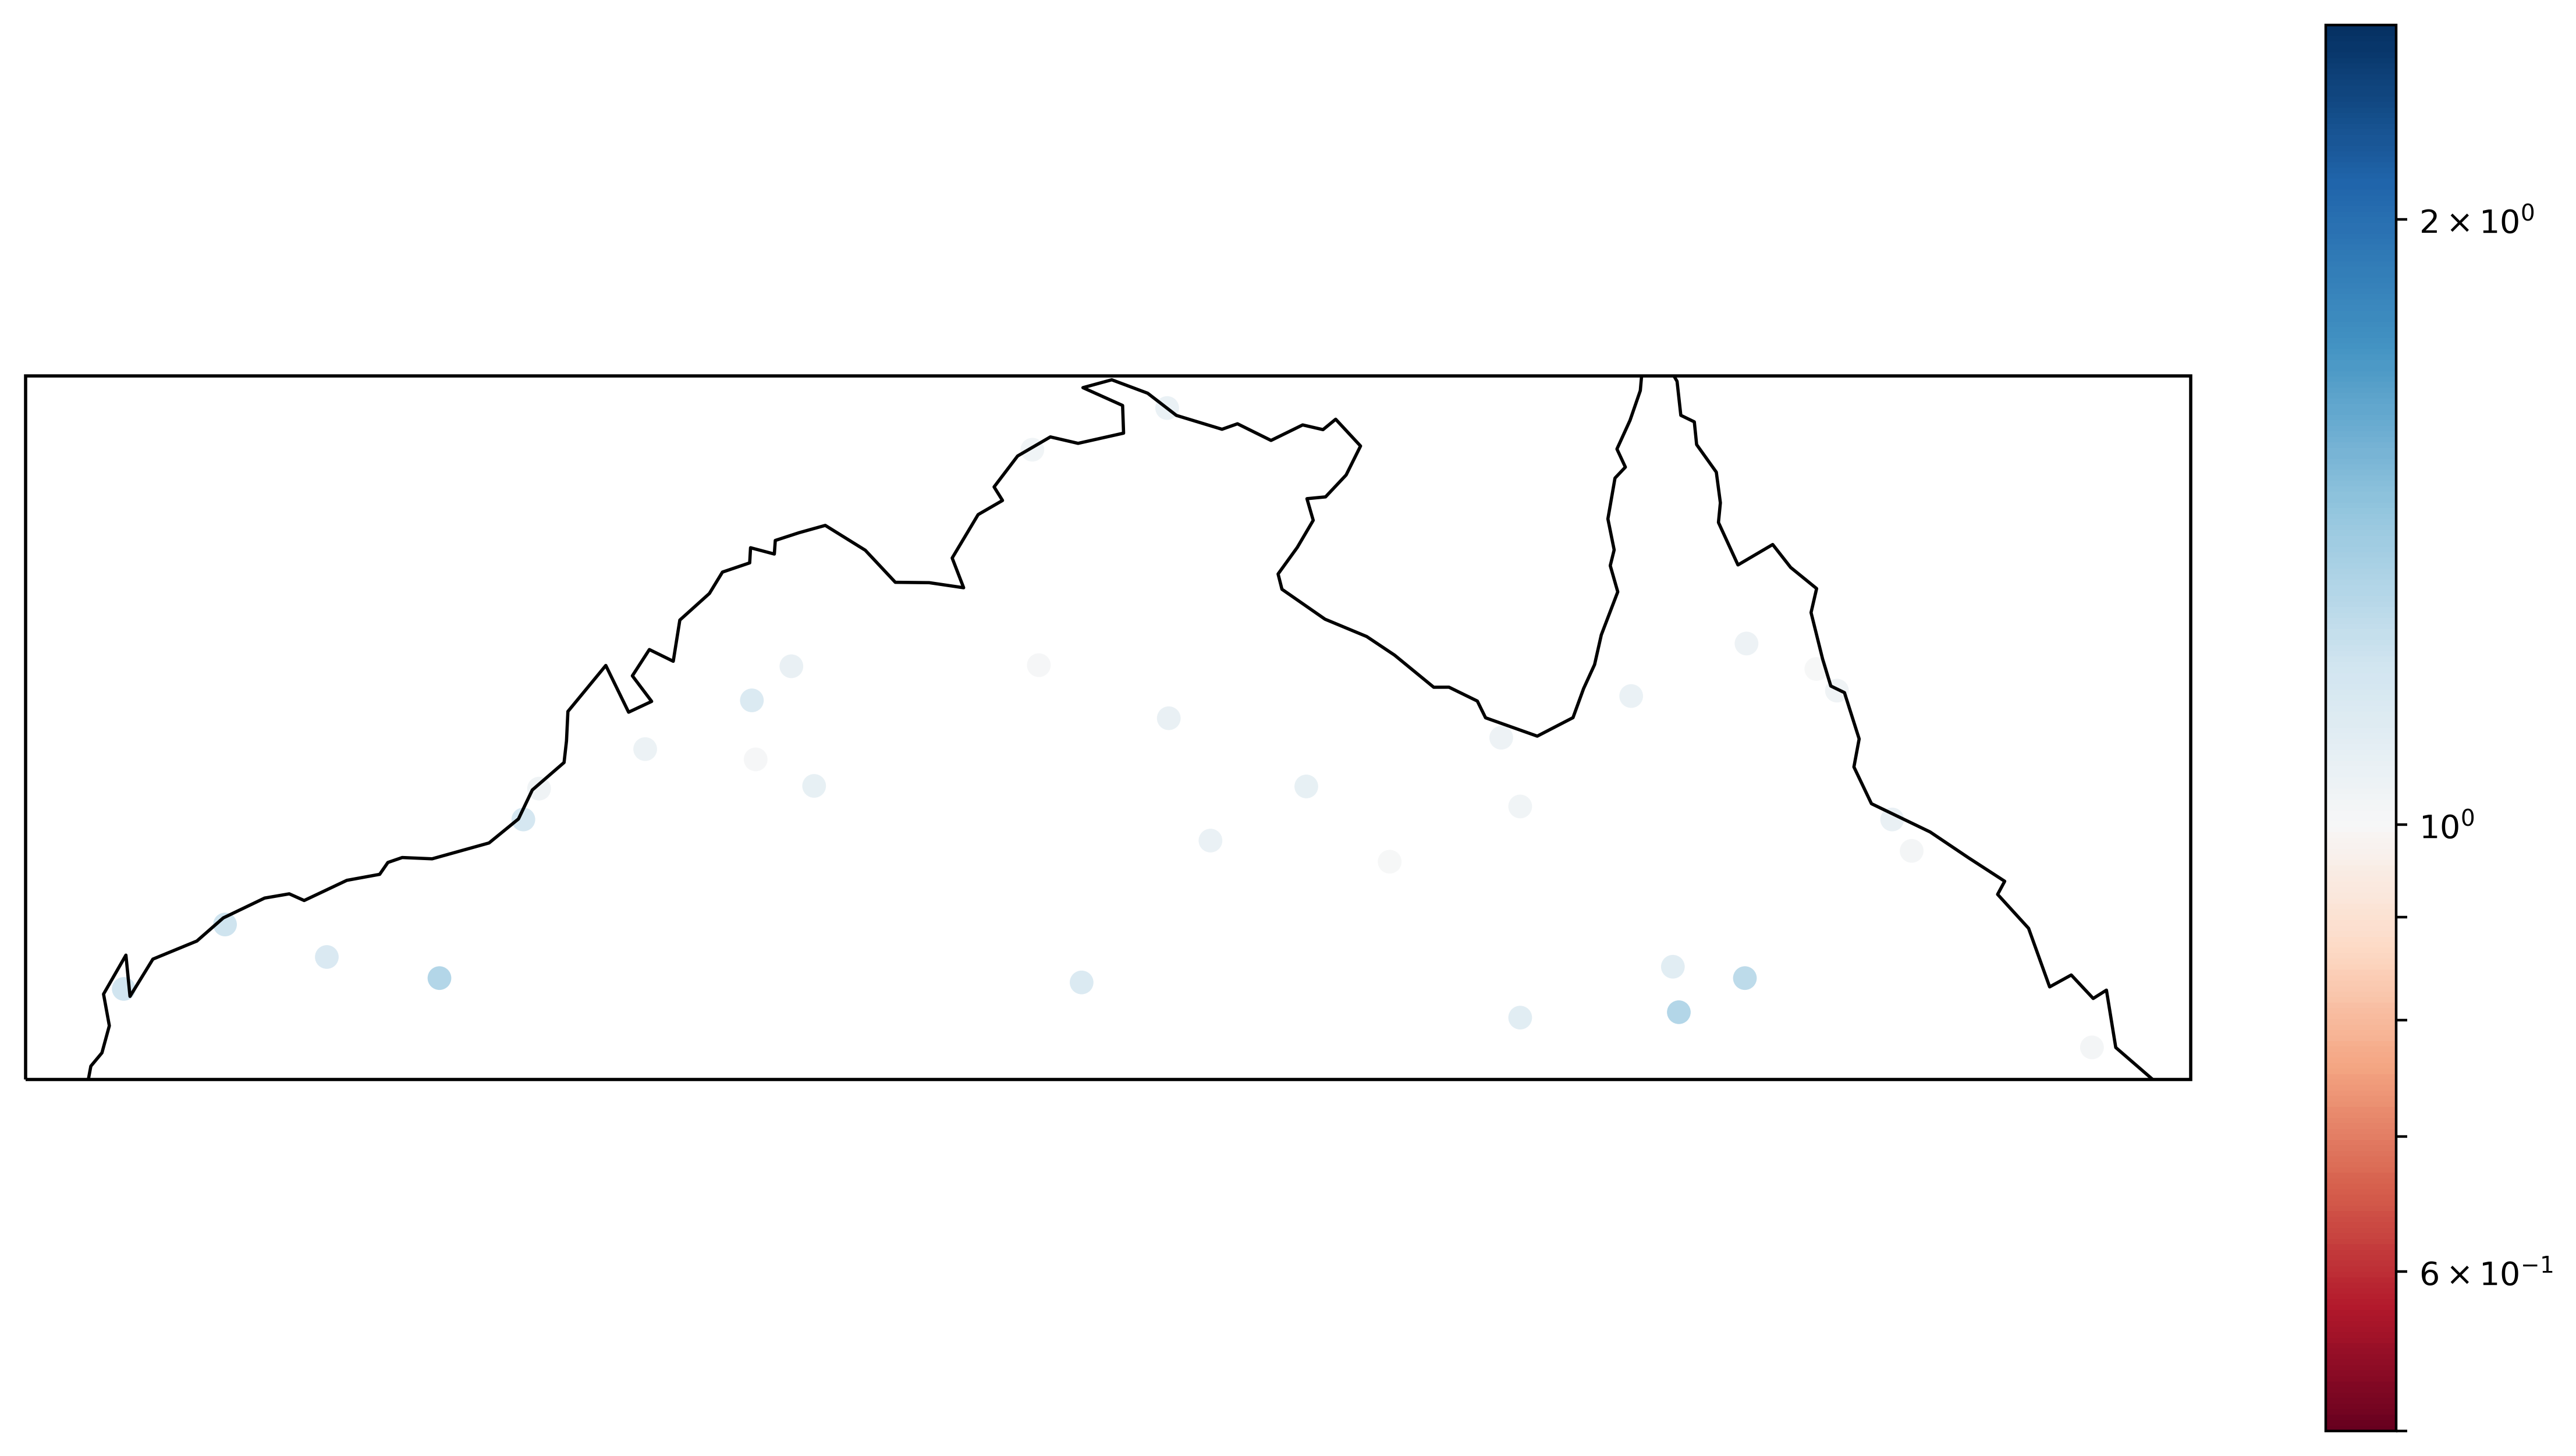

In [51]:
fig = plt.figure(figsize  = (15,8), dpi = 400)
ax = fig.add_subplot(1,1,1,projection = ccrs.PlateCarree())

data = station_count_90.sel(mjo = 'enhanced',month = 1)
vmax = 2.5
vmin = 0.5

plot = plt.scatter(data.lon.values,data.lat, s= 40,c = data.precip, cmap = rb,
            norm =  MidpointNormalizeLog(vmin = vmin, vmax = vmax, midpoint=1))
plt.colorbar(plot)

ax.coastlines()

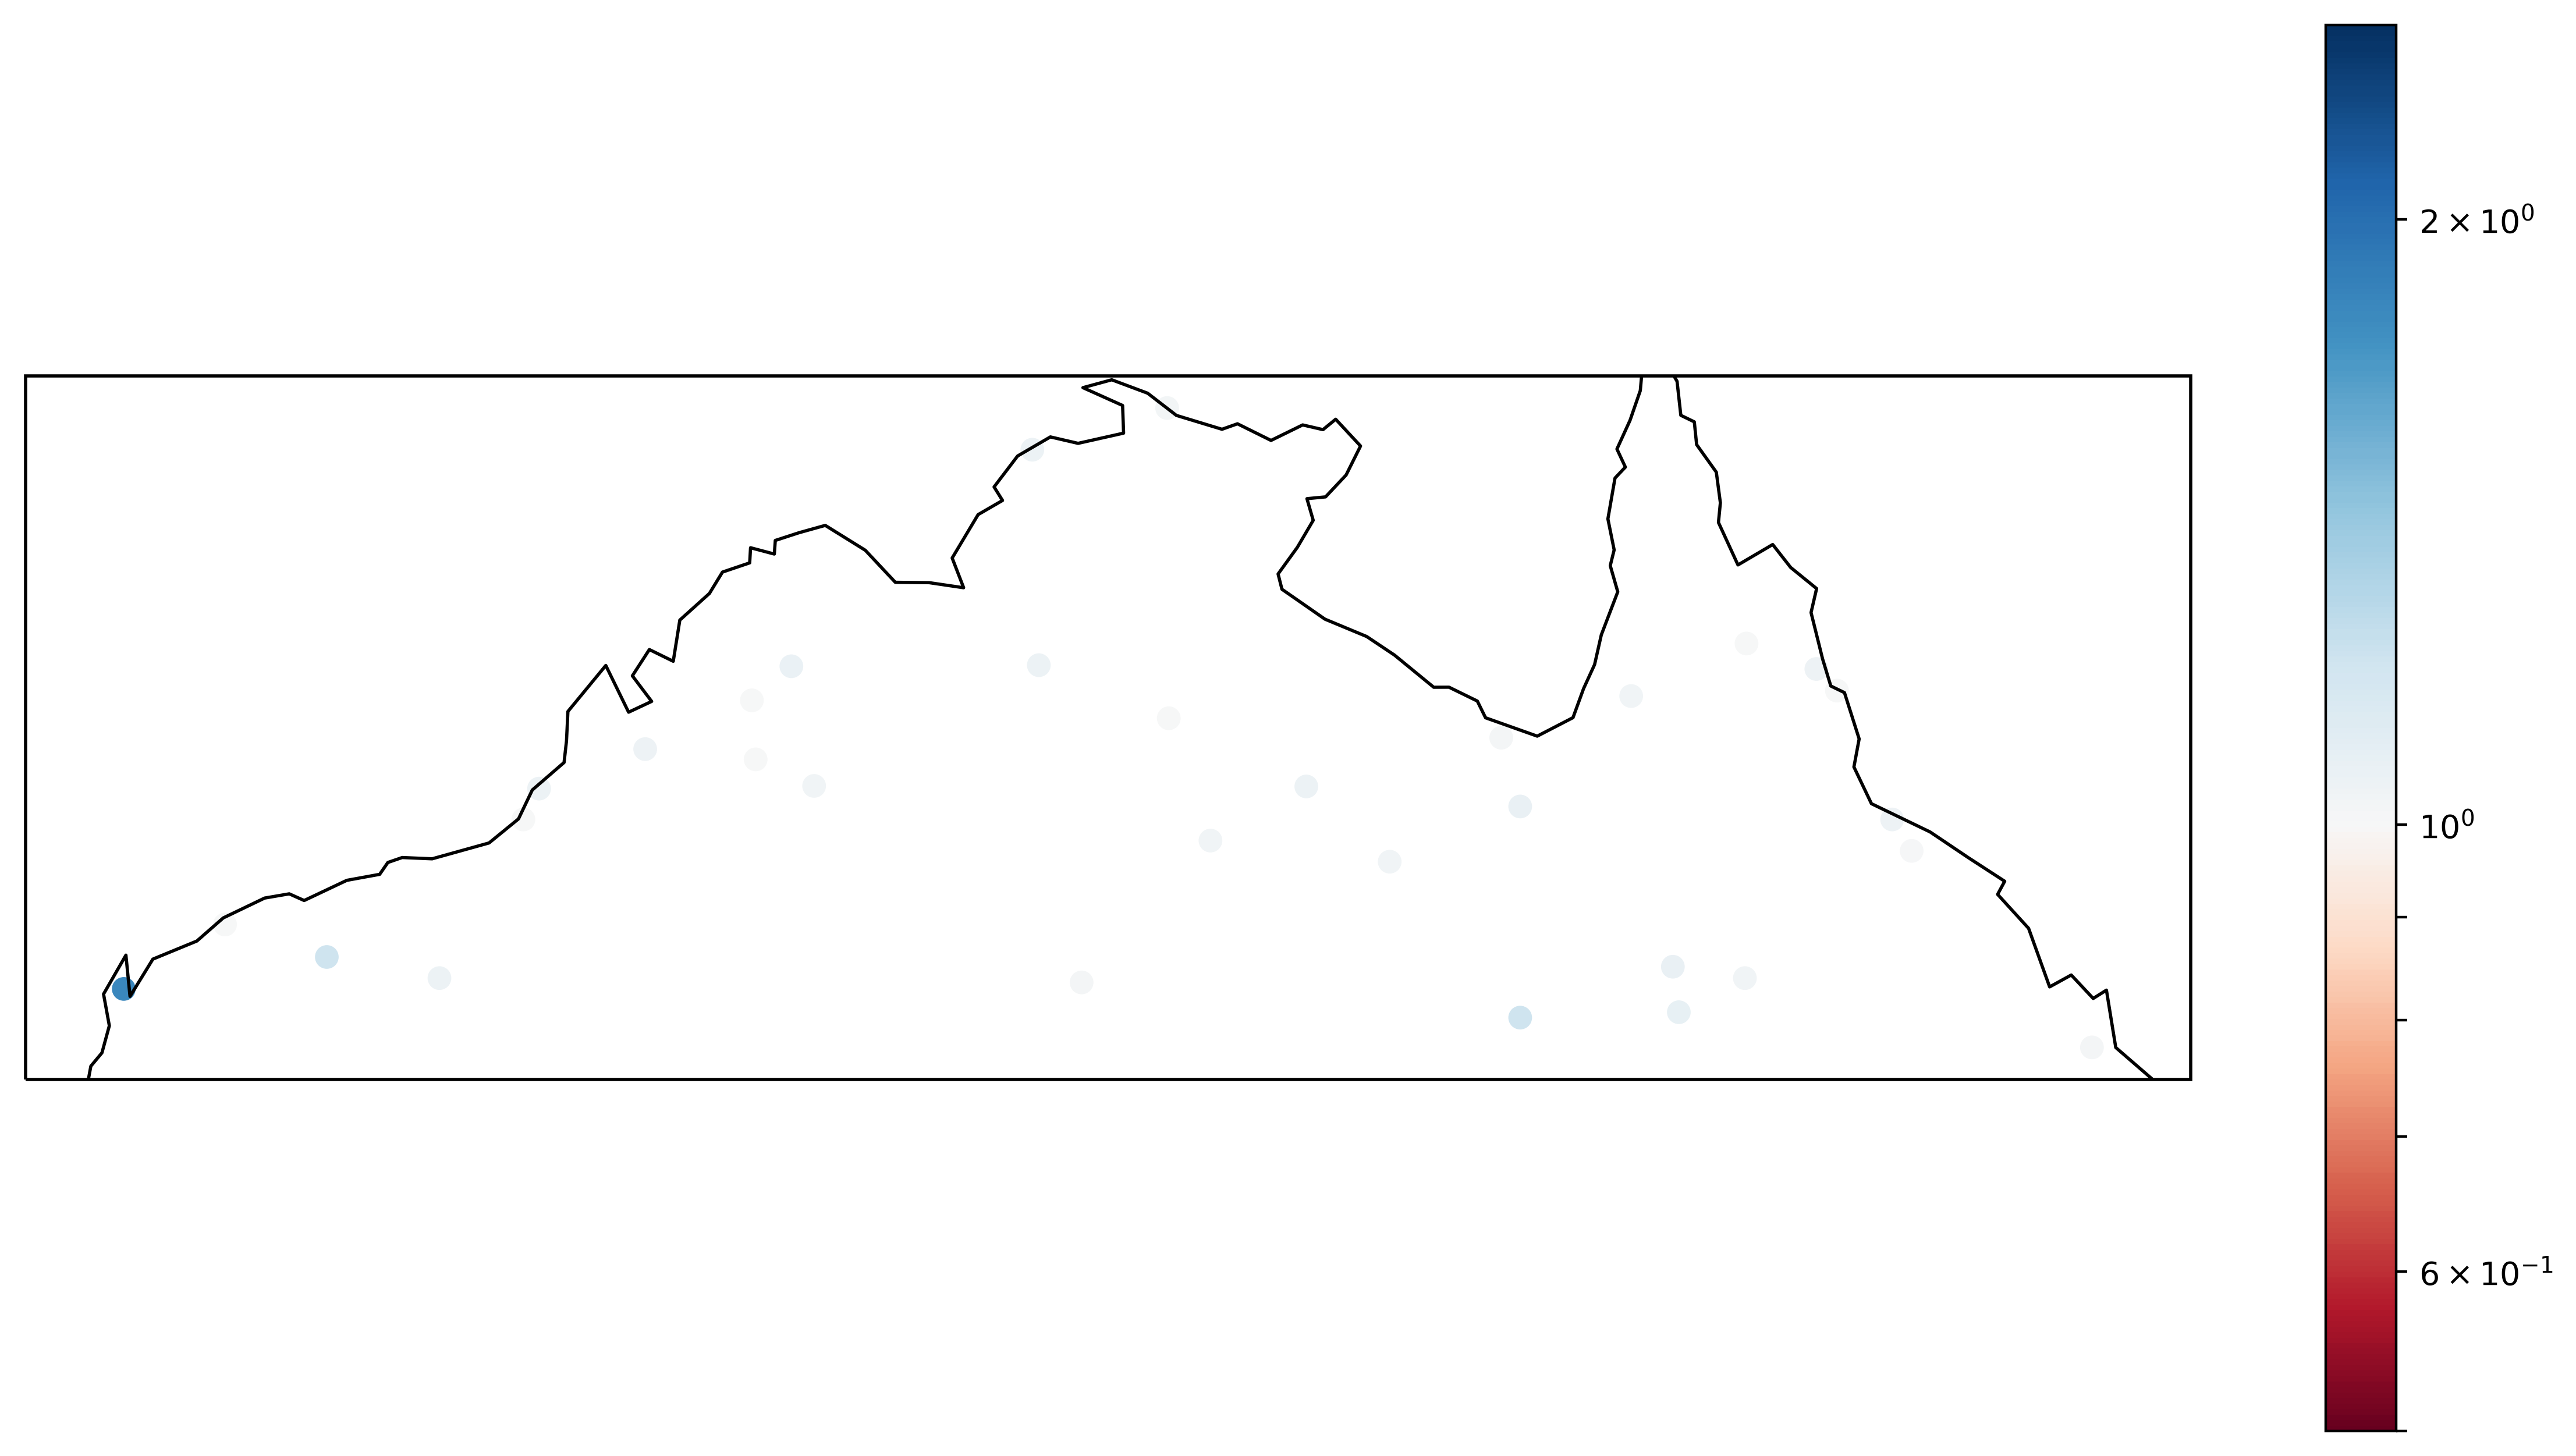

In [52]:
fig = plt.figure(figsize  = (15,8), dpi = 400)
ax = fig.add_subplot(1,1,1,projection = ccrs.PlateCarree())

data = station_count_90.sel(mjo = 'suppressed',month = 1)
vmax = 2.5
vmin = 0.5

plot = plt.scatter(data.lon.values,data.lat, s= 40,c = data.precip, cmap = rb,
            norm =  MidpointNormalizeLog(vmin = vmin, vmax = vmax, midpoint=1))
plt.colorbar(plot)

ax.coastlines()

# Bootstrapping

In [33]:
RMM_active = RMM[RMM['Amplitude'] >= 1]
RMM_inactive = np.array(RMM[RMM['Amplitude'] < 1].index)

In [34]:
enhanced_data, suppressed_data, inactive_data = mjo_phase_data(station_xr.isel(location = 11), [4,5,6])

In [35]:
def mjo_phase_data(data_sub, enhanced_phases):
    enhanced_dates = np.array(RMM_active[RMM_active['Phase'].isin(enhanced_phases)].index)
    suppressed_dates = np.array(RMM_active[~RMM_active['Phase'].isin(enhanced_phases)].index)
    
    enhanced_data = data_sub.where(data_sub.time.isin(enhanced_dates))
    suppressed_data = data_sub.where(data_sub.time.isin(suppressed_dates))
    inactive_data = data_sub.where(data_sub.time.isin(RMM_inactive))

    return enhanced_data, suppressed_data, inactive_data
    

In [36]:
def enhanced_phase_function(lon):
    if lon < 120:
        enhanced_phases = [4,5]
    if lon >= 120 and lon <140:
        enhanced_phases = [4,5,6]
    else:
        enhanced_phases = [4,5,6,7]
        
    return enhanced_phases

In [106]:
def into_xr_bs(storage):
    
    xr_file = xr.Dataset({'frac':(('location','month'),np.array(storage))},
                 {'location':station_xr.location.values, 'month':[10,11,12,1,2,3]})
    
    return xr_file

In [262]:
# This just moves all the data number * 100 years into the futre

def forward_in_time(additional, number):
    times = ((additional.time.dt.year.values + number *100 )* 10000 + 
                       additional.time.dt.month.values *100 + additional.time.dt.day.values)
    values = additional.precip.values
    
    future_time = []
    future_values = []
    
    for i in range(len(times)):
        time = times[i]
        try:
            thetime = pd.to_datetime(time,format = '%Y%m%d')
            future_time.append(thetime)
            future_values.append(values[i])
        except:
            pass
        

    xrd = xr.Dataset({'precip':(('time'), future_values)},
                {'time':future_time})

    return xrd
    


# * Contains 1 additional function 
def select_additional(data, years):
    
    number = 1
    uniqueValues, occurCount = np.unique(years, return_counts=True) 
    
    while(any(occurCount >= 2)):
        # Find the years that are getting sampled multiple times
        multi_sampled_years = uniqueValues[np.where(occurCount >= 2 )]
        
        additional = data.where(data.time.dt.year.isin(multi_sampled_years), drop = True)
        

        additional = forward_in_time(additional, number)
               
        data = data.combine_first(additional)
                                
        occurCount = occurCount - 1
        number += 1
        
    
    return data
        
    

In [263]:
# This function find the extremes for a specific station. THe a

def return_extremes_bs(data, q):
    
    # Finding the extreme threshhold for each of the months
    data_exthresh = data.precip.groupby('time.month').reduce(np.nanpercentile,q= q, dim = 'time')
    
    
    # Now going through and finding all of the extremes for each month
    months = [10,11,12,1,2,3]
    ex_storage = []
    
    for month in months:
        
        # This is just the data for a single month
        data_m = data.where(data.time.dt.month == month, drop = True)
        threshold = data_exthresh.sel(month = 1)
        data_ex  = data_m.where(data_m.precip >= threshold)
        ex_storage.append(data_ex)
        
    xr_file = (ex_storage[0].combine_first(ex_storage[1]).combine_first(ex_storage[2])
               .combine_first(ex_storage[3]).combine_first(ex_storage[4]).combine_first(ex_storage[5]))
    
    xr_file = drop_surplus_data(xr_file)
    
    return xr_file

In [264]:
data = station_xr.isel(location = 11)
test = return_extremes_bs(data, q)  

In [251]:
test

<xarray.Dataset>
Dimensions:   (time: 6653)
Coordinates:
  * time      (time) datetime64[ns] 1974-10-01 1974-10-02 1974-10-03 ...
    location  <U5 '14015'
    month     int64 1
Data variables:
    precip    (time) float64 dask.array<shape=(6653,), chunksize=(6653,)>

In [230]:
def calculate_month_prop_bs(data,data_ex):
    # The data_ex has been divided into months, but the data has not.
    
    data_count = data.precip.groupby('time.month').count(dim = 'time')
    data_ex_count = data_ex.precip.groupby('time.month').count(dim = 'time')
    
    prop = data_ex_count/data_count
    
    return prop
    

In [271]:

def calculate_station_prop_bs(data, q, loops):
    # For loops that goes through all stations
    enhanced_storage_10 = []
    suppressed_storage_10 = []
    inactive_storage_10 = []
    
    enhanced_storage_90 = []
    suppressed_storage_90 = []
    inactive_storage_90 = []
    
    years = np.arange(1974,2011)
    
    stations = np.array([data.location.values])[0][:1]
    for station in stations:

        # Getting the data just from these years
        data_sub = data.sel(location = station)
        data_sub_ex = return_extremes_bs(data_sub, q) #An array of the extreme values

        # Finding the enahnced phases:
        lon = station_xr.sel(location = station).lon.values
        enhanced_phases = enhanced_phase_function(lon)
        

        # Divide up into enhanced, suppressed and inactive
        enhanced, suppressed, inactive = mjo_phase_data(data_sub, enhanced_phases)
        
        
        # Finding the extreme of these phases
        enhanced_ex = return_extremes_bs(enhanced, q)
        suppressed_ex = return_extremes_bs(suppressed, q)
        inactive_ex = return_extremes_bs(inactive, q)

        # Calculate 90th percentile for each phase in each month
        enhanced_run_storage = []
        suppressed_run_storage = []
        inactive_run_storage = []
        
        for run in range(loops):
    
            # Get the good years for that station
            bad_years = MJO_df.loc[station].loc['Bad Wet Seasons']
            good_years = years[~np.isin(years,np.array(bad_years))]
            
            # Random years
            random_years = np.random.choice(good_years,
                                            size = np.ceil(len(good_years)/2).astype(int), replace = True )
            
            ####### Random of the Normal Phase Rain
            # Getting the data just from these years
            enhanced_rand = enhanced.where(enhanced.time.dt.year.isin(random_years), drop = True)
            suppressed_rand = suppressed.where(suppressed.time.dt.year.isin(random_years), drop = True)
            inactive_rand = inactive.where(inactive.time.dt.year.isin(random_years), drop = True)
            normal_rand = data_sub.where(data_sub.time.dt.year.isin(random_years), drop = True)
            
        
            # Dealing with the years sample multiple time
            enhanced_rand = select_additional(enhanced_rand, random_years)
            suppressed_rand = select_additional(suppressed_rand, random_years)
            inactive_rand = select_additional(inactive_rand, random_years)
            normal_rand = select_additional(normal_rand, random_years)
            
            
            ####### Random of the Extreme Phase Rain
            # Getting the data just from these years
            enhanced_rand_ex = enhanced_ex.where(enhanced_ex.time.dt.year.isin(random_years), drop = True)
            suppressed_rand_ex = suppressed_ex.where(suppressed_ex.time.dt.year.isin(random_years), drop = True)
            inactive_rand_ex = inactive_ex.where(inactive_ex.time.dt.year.isin(random_years), drop = True)
            normal_rand_ex = data_sub_ex.where(data_sub_ex.time.dt.year.isin(random_years), drop = True)
            
        

            #Dealing with the years sample multiple time
            enhanced_rand_ex = select_additional(enhanced_rand_ex, random_years)
            suppressed_rand_ex = select_additional(suppressed_rand_ex, random_years)
            inactive_rand_ex = select_additional(inactive_rand_ex, random_years)
            normal_rand_ex = select_additional(normal_rand_ex, random_years)
            
            

            ########Actual Calculation
            enhanced_q = calculate_month_prop_bs(enhanced_rand,enhanced_rand_ex)
            suppressed_q = calculate_month_prop_bs(suppressed_rand,suppressed_rand_ex)
            inactive_q = calculate_month_prop_bs(inactive_rand, inactive_rand_ex)
            normal_q = calculate_month_prop_bs(normal_rand, normal_rand_ex)

            # Do the Frac
            enhanced_frac = enhanced_q/normal_q
            suppressed_frac = suppressed_q/ normal_q
            inactive_frac = inactive_q/ normal_q
            
            
            #Storing the Results
            enhanced_run_storage.append(enhanced_frac)
            suppressed_run_storage.append(suppressed_frac)
            inactive_run_storage.append(inactive_frac)

        # Concatinating all the storages
        enhanced_total = xr.concat(enhanced_run_storage,  'run_num')
        suppressed_total = xr.concat(suppressed_run_storage,  'run_num')
        inactive_total = xr.concat(inactive_run_storage,  'run_num')
        
        
        #Calculating the 10th and 90th percentile
        enhanced_90 = enhanced_total.groupby('month').reduce(np.nanpercentile, q = 90)
        enhanced_10 = enhanced_total.groupby('month').reduce(np.nanpercentile, q = 10)
        
        suppressed_90 = suppressed_total.groupby('month').reduce(np.nanpercentile, q = 90)
        suppressed_10 = suppressed_total.groupby('month').reduce(np.nanpercentile, q = 10)
        
        inactive_90 = inactive_total.groupby('month').reduce(np.nanpercentile, q = 90)
        inactive_10 = inactive_total.groupby('month').reduce(np.nanpercentile, q = 10)


        # Storing all of 10th and 90th percentiles of run numbs
        enhanced_storage_90.append(enhanced_90)
        enhanced_storage_10.append(enhanced_10)
        
        suppressed_storage_90.append(suppressed_90)
        suppressed_storage_10.append(suppressed_10)
        
        inactive_storage_90.append(inactive_90)
        inactive_storage_10.append(inactive_10)
        
                                    
                                    
    # The concatination of all the stations
    enhanced_tot_90 = xr.concat(enhanced_storage_90, pd.Index(stations, name = 'location'))
    enhanced_tot_10 = xr.concat(enhanced_storage_10, pd.Index(stations, name = 'location'))
    enhanced_tot = xr.concat([enhanced_tot_90,enhanced_tot_10], pd.Index(['90','10'], name = 'percentile'))
    
    suppressed_tot_90 = xr.concat(suppressed_storage_90, pd.Index(stations, name = 'location'))
    suppressed_tot_10 = xr.concat(suppressed_storage_10, pd.Index(stations, name = 'location'))
    suppressed_tot = xr.concat([suppressed_tot_90,suppressed_tot_10], pd.Index(['90','10'], name = 'percentile'))
    
    inactive_tot_90 = xr.concat(inactive_storage_90, pd.Index(stations, name = 'location'))
    inactive_tot_10 = xr.concat(inactive_storage_10, pd.Index(stations, name = 'location'))
    inactive_tot = xr.concat([inactive_tot_90,inactive_tot_10], pd.Index(['90','10'], name = 'percentile'))
    
    return enhanced_tot,suppressed_tot,inactive_tot


    
    
    

In [274]:
data = station_xr
q = 90
loops = 1000
enhanced_90,suppressed_90,inactive_90 = calculate_station_prop_bs(data, q, loops)

In [427]:
stat_prop_boot_90 = xr.concat([enhanced_90,suppressed_90],
                             pd.Index(['enhanced', 'suppressed'], name = 'mjo'))

stat_prop_boot_90.to_netcdf('stat_prop_boot_90.nc')

In [428]:
data = station_xr
q = 95
loops = 1000
enhanced_95,suppressed_95,inactive_95 = calculate_station_prop_bs(data, q, loops)

In [429]:
stat_prop_boot_95 = xr.concat([enhanced_95,suppressed_95],
                             pd.Index(['enhanced', 'suppressed'], name = 'mjo'))

stat_prop_boot_95.to_netcdf('stat_prop_boot_95.nc')